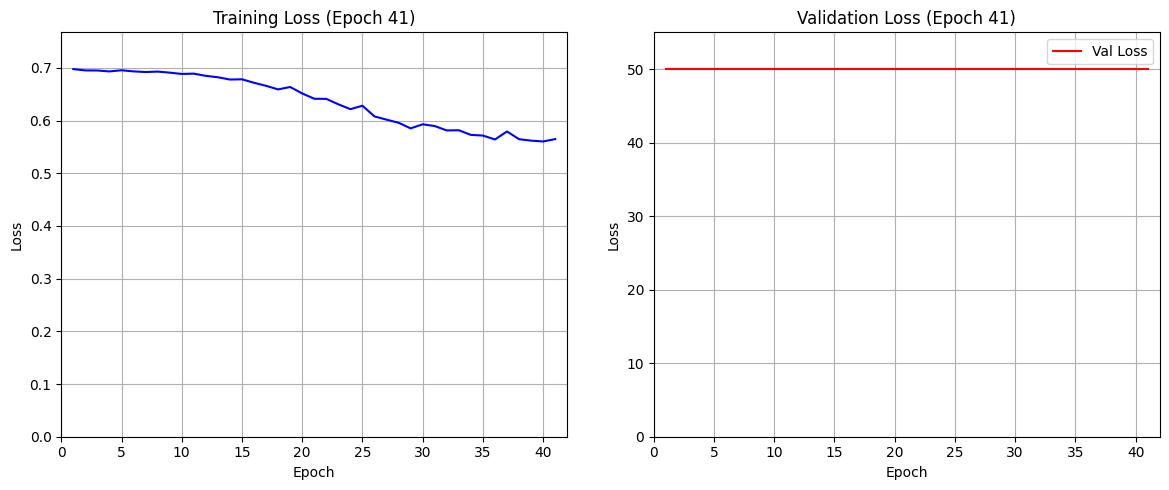

Epoch 42/500:  73%|███████▎  | 8/11 [00:00<00:00, 15.28it/s]

In [ ]:
import torch
from myocr.modeling.model import ModelZoo
from myocr.config import MODEL_PATH
from torchvision import transforms
from myocr.training.base import Trainer
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset
import os
from PIL import Image
from torch.utils.data import Subset
import random

DATA_PATH = "../training/dataset/textline_orientation"

model = ModelZoo.load_model("custom", "../modeling/configs/cls_mv3.yaml", "cuda:0" if torch.cuda.is_available() else "cpu")

class CustomDataset(Dataset):
    def __init__(self, list_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # Read the list file
        with open(list_file, 'r') as f:
            lines = f.readlines()
        
        # Parse the lines (assuming format: "class/img_name.jpg")
        self.samples = []
        for line in lines:
            line = line.strip()
            if line:  # skip empty lines
                parts = line.split(' ')
                img_name = parts[0]
                class_id = parts[1]
                self.samples.append((os.path.join(root_dir, img_name), int(class_id)))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((100, 50)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((100, 50)),
    transforms.CenterCrop(100),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = CustomDataset(
    list_file=f'{DATA_PATH}/train_list.txt',
    root_dir=DATA_PATH,
    transform=train_transform
)

val_dataset = CustomDataset(
    list_file=f'{DATA_PATH}/val_list.txt',
    root_dir=DATA_PATH,
    transform=val_transform
)
N = 2600
indices = random.sample(range(len(train_dataset)), N)
trainer = Trainer(model,[], nn.CrossEntropyLoss(), optimizer=Adam(model.parameters(), lr=0.001), num_epochs=500, batch_size = 250)
trainer.fit(Subset(train_dataset, indices), val_dataset)
model.to_onnx(f"{MODEL_PATH}cls_train.onnx" , torch.randn((10,3,48,137), dtype=torch.float32).to("cuda:0"))
